In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics

from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Build Model

#### Set Hyperparameters

In [5]:
# random seed for consistency in pytorch and numpy
SEED = 23

torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
# learning rate
alpha = 0.00001

In [7]:
# epochs
epochs = 100

In [8]:
# number of batches
batches = 256

In [9]:
writer = SummaryWriter("frenchC2Cdata")

#### Determine device, CPU or GPU

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Neural Network

In [11]:
class MLP(nn.Module):
    
    def __init__(self, in_size):
        super(MLP, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_size, 100),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        out = self.linear_stack(x)

        return out

In [12]:
class MLP_tanh(nn.Module):
    
    def __init__(self, in_size):
        super(MLP_tanh, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_size, 19),
            nn.ReLU(),
            nn.Linear(19,5),
            nn.ReLU(),
            nn.Linear(5,1),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        out = self.linear_stack(x)

        return out

## Data

#### Dataset helper class for PyTorch framework to process tabular data

In [13]:
class dataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data, dtype=torch.float32, device=device)
        self.y = torch.tensor(target, dtype=torch.float32, device=device)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

#### Retrieve and check data

In [14]:
data = pd.read_csv("french_expanded.csv")

In [15]:
data.shape

(98913, 224)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Columns: 224 entries, socialNbFollowers to language_it
dtypes: bool(4), float64(2), int64(218)
memory usage: 166.4 MB


#### Separate features and target (ie, IV and DV, X and y)

In [17]:
X = data.drop("target", axis=1).values.astype(np.float32)
y = data.target.values.astype(np.float32)

#### Split data into train and test. Do not stratify, for baseline

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [19]:
training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)

In [20]:
training = DataLoader(training_data, batch_size=batches)
testing = DataLoader(testing_data, batch_size=batches)

## Train & Test model

In [24]:
def train(data, model, criterion, metric, optimizer):
    storage_X = []
    storage_y = []
    size = len(data.dataset)
    
    for batch, (X, y_actual) in enumerate(data, 0):
        
        #y_hat = model(X)
        y_hat = model_tanh(X)
        loss = criterion(y_hat, y_actual)
        
        # need to convert y from float to int for accuracy metric
        y = y_actual.int()
        acc = metric(y_hat, y)
        
        #  backprop step
        optimizer.zero_grad() # zero out the gradients
        loss.backward()       # backward pass through model; computes gradients
        optimizer.step()      # update weights
        
        # every 50 batches, store the results
        if batch % 50 == 0:
            storage_X.append(y_hat)
            storage_y.append(y)
            training_loss.append(loss)
            training_accuracy.append(acc)
            current = batch * len(X)
        
            print(f"loss:{loss:1.10f}\taccuracy:{acc:1.10f}\t [{current:6d}/{size:6d}]")
    
    return storage_X, storage_y

In [25]:
def test(data, model, criterion, metric):
    size = len(data.dataset)
    batches = len(data)
    tst_loss = 0
    correct = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X, y in data:
            y_hat = model(X)
            y = y.unsqueeze(-1)
            tst_loss += criterion(y_hat, y).item()
            
            y = y.int()
            acc = metric(y_hat, y)
            predictions.append(y_hat)
            actuals.append(y)
            
    tst_loss /= batches
    correct /= size
    
    print(f"Test error:\n\tAccuracy: {acc:0.5f}, Average loss: {tst_loss:10f}\n")
    return predictions, actuals

In [26]:
def train2(data, model, criterion, metric, optimizer):
    size = len(data.dataset)
    batches = len(data)
    running_loss = []
    acc = 0.0
    correct = 0
    predictions = []
    actuals = []
    
    for batch, (X, y) in enumerate(data,1):
        
        # forward step
        optimizer.zero_grad() # zero out the gradients
        y_hat = model(X)  #forward pass
        
        y = y.unsqueeze(-1) # reduce dimensions of tensor from [256, 1] to [256]
        
        loss = criterion(y_hat, y)  # calculate loss
       
        #  backprop step
        loss.backward()       # backward pass through model; computes gradients
        optimizer.step()      # update weights
        
        # metrics
        y = y.int()
        acc = metric(y_hat, y)

        predictions.append(y_hat)
        actuals.append(y)
            
        running_loss.append(loss.item())
    
        # every 50 batches, store the results
        if batch % size == 0:
            current = batch * len(X)
        
            print(f"loss:{loss:1.10f}\taccuracy:{acc:1.10f}\t [{current:6d}/{size:6d}]")
    
    return predictions, actuals, running_loss

In [29]:
def scoring2(prediction, actual):
    temp = []

    for el in prediction:
        temp.append(el.cpu().detach().numpy())
    
    prediction = np.array(temp, dtype=object)[0].reshape(-1)
    
    temp = []
    for el in actual:
        temp.append(el.cpu().detach().numpy())
        
    actual = np.array(temp, dtype=object)[0].reshape(-1)

    # create a confusion matrix heatmap
    cm = confusion_matrix(np.round(prediction), actual)
    cm = pd.DataFrame(cm/np.sum(cm),
                      index=["Predicted False", "Predicted True"],
                      columns=["Actual False", "Actual True"])

    return prediction, actual, cm

# Training Cycle

#### Construct model

In [21]:
model = MLP(X_train.shape[1]).to(device)
print(model.named_parameters)

<bound method Module.named_parameters of MLP(
  (linear_stack): Sequential(
    (0): Linear(in_features=223, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)>


In [22]:
model_tanh = MLP_tanh(X_train.shape[1]).to(device)
print(model_tanh.named_parameters)

<bound method Module.named_parameters of MLP_tanh(
  (linear_stack): Sequential(
    (0): Linear(in_features=223, out_features=19, bias=True)
    (1): ReLU()
    (2): Linear(in_features=19, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
    (5): Tanh()
  )
)>


#### Optimizer and Loss/Criterion Function

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
criterion = nn.BCELoss()
accuracy = torchmetrics.functional.accuracy

#### Train model

In [27]:
training_loss = []
training_accuracy = []

test_loss = []
test_accuracy = []

trng_predictions = []
test_predictions = []

for epoch in range(1,epochs+1):
    print (f"* * * * * * * * * *\nEpoch {epoch}")
    
    training_result, trng_actual, loss = train2(training, model, criterion, accuracy, optimizer)
    testing_result, test_actual = test(testing, model, criterion, accuracy)

    training_loss.append(loss)
    
print("Finished")

* * * * * * * * * *
Epoch 1
loss:0.6294394135	accuracy:0.7695312500	 [ 12800/ 69239]
loss:0.3769294620	accuracy:0.8632812500	 [ 25600/ 69239]
loss:0.2742008567	accuracy:0.8984375000	 [ 38400/ 69239]
loss:0.2475699484	accuracy:0.8945312500	 [ 51200/ 69239]
loss:0.2085981816	accuracy:0.9140625000	 [ 64000/ 69239]
Test error:
	Accuracy: 0.90598, Average loss:   0.214432

* * * * * * * * * *
Epoch 2
loss:0.2206004560	accuracy:0.9179687500	 [ 12800/ 69239]
loss:0.1886506528	accuracy:0.9335937500	 [ 25600/ 69239]
loss:0.1655074358	accuracy:0.9492187500	 [ 38400/ 69239]
loss:0.2007668465	accuracy:0.9531250000	 [ 51200/ 69239]
loss:0.1725510657	accuracy:0.9570312500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.94444, Average loss:   0.185946

* * * * * * * * * *
Epoch 3
loss:0.1930462867	accuracy:0.9531250000	 [ 12800/ 69239]
loss:0.1704328209	accuracy:0.9531250000	 [ 25600/ 69239]
loss:0.1532394141	accuracy:0.9453125000	 [ 38400/ 69239]
loss:0.1965747774	accuracy:0.9414062500	 [ 51200/ 69239]
lo

loss:0.1430437863	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1514159292	accuracy:0.9453125000	 [ 38400/ 69239]
loss:0.1930170208	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1487081498	accuracy:0.9531250000	 [ 64000/ 69239]
Test error:
	Accuracy: 0.95726, Average loss:   0.161762

* * * * * * * * * *
Epoch 24
loss:0.1494494081	accuracy:0.9648437500	 [ 12800/ 69239]
loss:0.1427440494	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1510269195	accuracy:0.9453125000	 [ 38400/ 69239]
loss:0.1926331818	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1484057009	accuracy:0.9531250000	 [ 64000/ 69239]
Test error:
	Accuracy: 0.95726, Average loss:   0.161246

* * * * * * * * * *
Epoch 25
loss:0.1489367187	accuracy:0.9648437500	 [ 12800/ 69239]
loss:0.1424891502	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1506838799	accuracy:0.9453125000	 [ 38400/ 69239]
loss:0.1922491789	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1482081264	accuracy:0.9531250000	 [ 64000/ 69239]
Test error:
	Accuracy: 0.957

loss:0.1784634590	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1403859258	accuracy:0.9570312500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.96154, Average loss:   0.147558

* * * * * * * * * *
Epoch 46
loss:0.1369185150	accuracy:0.9687500000	 [ 12800/ 69239]
loss:0.1345201433	accuracy:0.9570312500	 [ 25600/ 69239]
loss:0.1374451816	accuracy:0.9414062500	 [ 38400/ 69239]
loss:0.1775609106	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1399704516	accuracy:0.9570312500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.95726, Average loss:   0.146703

* * * * * * * * * *
Epoch 47
loss:0.1361417472	accuracy:0.9687500000	 [ 12800/ 69239]
loss:0.1338254213	accuracy:0.9570312500	 [ 25600/ 69239]
loss:0.1364021897	accuracy:0.9414062500	 [ 38400/ 69239]
loss:0.1766864657	accuracy:0.9375000000	 [ 51200/ 69239]
loss:0.1391735375	accuracy:0.9570312500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.95726, Average loss:   0.145786

* * * * * * * * * *
Epoch 48
loss:0.1352042556	accuracy:0.9687500000	 [ 12800/ 69239

Test error:
	Accuracy: 0.96154, Average loss:   0.125502

* * * * * * * * * *
Epoch 68
loss:0.1163701117	accuracy:0.9687500000	 [ 12800/ 69239]
loss:0.1167632267	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1106676310	accuracy:0.9570312500	 [ 38400/ 69239]
loss:0.1526723355	accuracy:0.9453125000	 [ 51200/ 69239]
loss:0.1237869114	accuracy:0.9648437500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.96154, Average loss:   0.124416

* * * * * * * * * *
Epoch 69
loss:0.1153905913	accuracy:0.9687500000	 [ 12800/ 69239]
loss:0.1158014163	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1091901511	accuracy:0.9570312500	 [ 38400/ 69239]
loss:0.1512915492	accuracy:0.9453125000	 [ 51200/ 69239]
loss:0.1228952259	accuracy:0.9648437500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.96154, Average loss:   0.123303

* * * * * * * * * *
Epoch 70
loss:0.1142898649	accuracy:0.9687500000	 [ 12800/ 69239]
loss:0.1147795543	accuracy:0.9609375000	 [ 25600/ 69239]
loss:0.1075594723	accuracy:0.9570312500	 [ 38400/ 69239

loss:0.0895452201	accuracy:0.9687500000	 [ 25600/ 69239]
loss:0.0824597180	accuracy:0.9765625000	 [ 38400/ 69239]
loss:0.1167619079	accuracy:0.9648437500	 [ 51200/ 69239]
loss:0.1000774875	accuracy:0.9726562500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.96581, Average loss:   0.095150

* * * * * * * * * *
Epoch 91
loss:0.0866882429	accuracy:0.9726562500	 [ 12800/ 69239]
loss:0.0881120712	accuracy:0.9687500000	 [ 25600/ 69239]
loss:0.0813495666	accuracy:0.9765625000	 [ 38400/ 69239]
loss:0.1150143296	accuracy:0.9648437500	 [ 51200/ 69239]
loss:0.0987479314	accuracy:0.9726562500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.97009, Average loss:   0.093702

* * * * * * * * * *
Epoch 92
loss:0.0852212608	accuracy:0.9726562500	 [ 12800/ 69239]
loss:0.0867222697	accuracy:0.9687500000	 [ 25600/ 69239]
loss:0.0802113563	accuracy:0.9765625000	 [ 38400/ 69239]
loss:0.1132371575	accuracy:0.9687500000	 [ 51200/ 69239]
loss:0.0974825919	accuracy:0.9726562500	 [ 64000/ 69239]
Test error:
	Accuracy: 0.970

## Visualize Results

In [28]:
def scoring(prediction, actual, test=False):
    
    # convert from pytorch tensors to numpy arrays
    temp_pred = []
    temp_act = []
    
    for element in prediction:
        for el in element:
            if el[0]:
                temp_pred.append(el[0].detach().cpu().numpy())
            else:
                temp_pred.append(el.detach().cpu().numpy())
    
    
    for element in actual:
        try:
            for el in element:
                temp_act.append(el.detach().cpu().numpy())
        except:
            temp_act.append(element.detach().cpu().numpy())
            
    prediction = np.array(temp_pred).round().astype(int)
    actual = np.array(temp_act)
    
    
    # create a confusion matrix heatmap
    cm = confusion_matrix(prediction, actual)
    cm = pd.DataFrame(cm/np.sum(cm),
                      index=["Predicted False", "Predicted True"],
                      columns=["Actual False", "Actual True"])
    
    return prediction, actual, cm

In [30]:
p, a, cm = scoring2(training_result, trng_actual)

In [31]:
TP, TN = 0, 0
FP, FN = 0, 0
for i, j in list(zip(np.round(p), a)):
    if (i == j) and (i == 1):
        TP += 1
    elif (i == j) and (i == 0):
        TN += 1
    elif (i != j) and (i == 1):
        FP += 1
    elif (i != j) and (i == 0):
        FN += 1
print(TP, TN, FP, FN)        

4 249 0 3


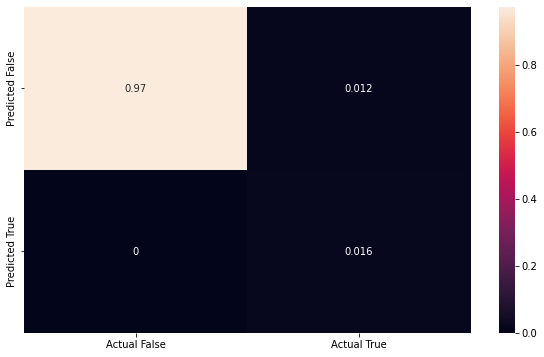

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True)
plt.show()

In [33]:
trng, _ = next(iter(training_data))

In [34]:
#writer.add_pr_curve('Precision Recall Curve', actual, predictions, 0)
writer.add_graph(model, trng)
writer.add_figure("Confusion Matrix", sns.heatmap(cm, annot=True).get_figure())

<AxesSubplot:>

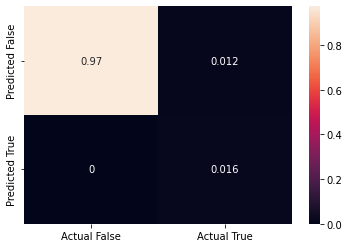

In [37]:
sns.heatmap(cm, annot=True)

In [38]:
temp = []
for element in training_loss:
    for el in element:
        temp.append(el)
    
loss = np.array(temp)

In [39]:
range(len(loss))

range(0, 27100)

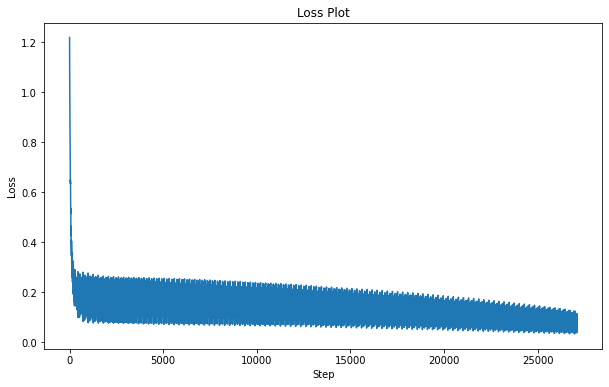

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(10,6))
plt.plot(range(len(loss)), loss)
plt.title("Loss Plot")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()
plt.savefig("lossplot.png")

In [43]:
for x in range(len(loss)):
    writer.add_scalar("Loss Plot", loss[x], x)

In [44]:
(len(data)-data.target.sum())/len(data)

0.9452144814129588

# NOTES

#### 2022 Apr 11 @ 1920 PDT

1) Model is trivially accurate. 94.5% of the data are negative. This imbalance needs to be addressed for the frenchC2C dataset.

2) Implement the tensorboard summarywriter upstream to capture data en route.

In [45]:
writer.close()

#### Display on Tensorboard

In [46]:
%load_ext tensorboard

In [47]:
!tensorboard --logdir=frenchC2Cdata

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


##### Note:
* Click the link localhost:6006 to open Tensorboard.
* Tensorboard must be terminated manually by closing the window and stopping the kernel for the executing cell